Suppose we now have a base model we want to explore more for fine-tuningin a more complicated way. We could think of adding on a MLP head.![1_-IPQlOd46dlsutIbUq1Zcw.png](https://miro.medium.com/v2/resize:fit:720/format:webp/1*-IPQlOd46dlsutIbUq1Zcw.png)

In [1]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation=nn.ReLU()):
        """
        Initialize a Multi-Layer Perceptron (MLP)
        
        Args:
            input_size (int): Number of input features
            hidden_sizes (list): List of hidden layer sizes
            output_size (int): Number of output neurons
            activation (nn.Module, optional): Activation function. Defaults to ReLU.
        """
        super(MLP, self).__init__()
        
        # Create layers list
        layers = []
        
        # Input to first hidden layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(activation)
        
        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(activation)
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        # Create sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass through the MLP
        
        Args:
            x (torch.Tensor): Input tensor
        
        Returns:
            torch.Tensor: Output tensor
        """
        return self.model(x)



In [2]:
# Create an MLP with:
# - 10 input features
# - Hidden layers of sizes [64, 32]
# - 5 output neurons
# - ReLU activation
model = MLP(input_size=10, 
                hidden_sizes=[64, 32], 
                output_size=5)
    
# Generate random input
x = torch.randn(1, 10)
    
# Forward pass
output = model(x)
print(output)

tensor([[-0.2772, -0.2452, -0.2040, -0.0534,  0.1671]],
       grad_fn=<AddmmBackward0>)


### Data Pipeline Architecture

```mermaid
graph LR
    A[Raw Protein Data] --> B[ProteinDataset]
    B --> C[DataLoader]
    C --> D[ProteinClassifier]
    D --> E[Training Loop]
```

**Detailed Pipeline Steps:**
1. **Raw Protein Data**: Sequences in FASTA format or similar
2. **ProteinDataset**: Custom PyTorch Dataset class for efficient data handling
3. **DataLoader**: Batches data and enables parallel processing
4. **ProteinClassifier**: Model architecture combining pre-trained model and task-specific layers
5. **Training Loop**: Iterative process of model optimization

### Raw Protein Data

Lets write the function that takes in the protein data.

In [3]:
import pandas as pd

def load_sequences(data_csv, n_samples):
    df = pd.read_csv(data_csv)
    small_df = df.groupby('label/fitness')['sequence'].apply(lambda s: s.sample(n_samples)).reset_index()

    return small_df['sequence'].tolist(), small_df['label/fitness'].tolist()

### ProteinDataSet

In [4]:
from torch.utils.data import Dataset, DataLoader

class ProteinDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
        
    def __len__(self):
        return len(self.sequences)
        
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        
        inputs = tokenizer(
            sequence, 
            padding='max_length', 
            max_length=512, 
            truncation=True
        )
        return {
            'input_ids': torch.tensor(inputs['input_ids']),
            'attention_mask': torch.tensor(inputs['attention_mask']),
            'labels': torch.tensor(label)
        }

### Modified MLP to take the intial model into account

In [5]:
import torch
import torch.nn as nn

class Modified_MLP(nn.Module):
    def __init__(self, pretrained_model, hidden_sizes, output_size, activation=nn.ReLU()):
        """
        Initialize a Multi-Layer Perceptron (MLP)
        
        Args:
            input_size (int): Number of input features
            hidden_sizes (list): List of hidden layer sizes
            output_size (int): Number of output neurons
            activation (nn.Module, optional): Activation function. Defaults to ReLU.
        """
        super().__init__()
        
        self.pretrained_model = pretrained_model
        # Create layers list
        self.layers = []
        
        # Input to first hidden layer
        self.layers.append(nn.Linear(pretrained_model.config.hidden_size, hidden_sizes[0]))
        self.layers.append(activation)
        
        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.layers.append(activation)
        
        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        # Create sequential model
        self.model = nn.Sequential(*self.layers)

    def forward(self, input_ids, attention_mask):
        # Get embeddings from pretrained model
        outputs = self.pretrained_model(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        sequence_output = outputs[0]
        
        # Average pooling
        pooled_output = torch.mean(sequence_output, dim=1)
        # Classification
        return self.model(pooled_output)

### Create the training loop 

In [ ]:
# Training step
def train_model(model, train_loader, val_loader, optimizer, num_epochs, device):
    best_val_accuracy = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.train()

    for epoch in range(num_epochs):
        epoch_train_losses = []
        epoch_predictions = []
        epoch_labels = []

        for batch in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            
            # Get batch data (this comes from ProteinDataset)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass (using ProteinClassifier)
            outputs = model(input_ids, attention_mask)
            
            # Calculate loss
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            epoch_train_losses.append(loss.item())
            epoch_predictions.append(outputs.detach())
            epoch_labels.append(labels)
            
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

        # Calculate training metrics for the epoch
        epoch_predictions = torch.cat(epoch_predictions, dim=0)
        epoch_labels = torch.cat(epoch_labels, dim=0)
        train_accuracy = compute_metrics(epoch_predictions, epoch_labels)
        train_loss = np.mean(epoch_train_losses)
        
        # Validation phase
        val_loss, val_accuracy = evaluate(model, val_loader, device)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        # Save best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            print("Saved new best model!")
        
        print("-" * 50)

        return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

### Create an evaluation loop

In [9]:
from sklearn.metrics import accuracy_score
import numpy as np
def compute_metrics(predictions, labels):
    # Convert predictions to class labels
    pred_labels = torch.argmax(predictions, dim=1).cpu().numpy()
    true_labels = labels.cpu().numpy()
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, pred_labels)
    return accuracy

def evaluate(model, val_loader, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            
            total_loss += loss.item()
            all_predictions.append(outputs)
            all_labels.append(labels)
    
    # Concatenate all predictions and labels
    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Calculate metrics
    accuracy = compute_metrics(all_predictions, all_labels)
    avg_loss = total_loss / len(val_loader)
    
    return avg_loss, accuracy

### Initiate the DataLoader and start training

In [12]:
from transformers import EsmModel, EsmTokenizer

#Define where we load our data:

train = '../DeepLoc_cls2_data/cls2_normal_train.csv'
valid = '../DeepLoc_cls2_data/cls2_normal_valid.csv'
test = '../DeepLoc_cls2_data/cls2_normal_test.csv'


train_sequences, train_labels = load_sequences(train, 100)
val_sequences, val_labels = load_sequences(train, 20)
test_sequences, test_labels = load_sequences(train, 20)

train_dataset = ProteinDataset(train_sequences, train_labels)
train_loader = DataLoader(
    train_dataset,
    batch_size = 32,
    shuffle=True
)
val_dataset = ProteinDataset(val_sequences, val_labels)
val_loader = DataLoader(
    train_dataset,
    batch_size = 32,
    shuffle=True
)

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# Load ESM model and tokenizer
model_name = "facebook/esm2_t6_8M_UR50D"
pretrained_model = EsmModel.from_pretrained(model_name)
tokenizer = EsmTokenizer.from_pretrained(model_name)

model = Modified_MLP(pretrained_model, [128, 128, 128], 5)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train
history = train_model(model, train_loader, val_loader, optimizer, 2, 'cpu')
# torch.save(model.state_dict(), 'model_weights.pth')

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0, Loss: 1.6301
Epoch 0, Loss: 1.6090
Epoch 0, Loss: 1.6053
Epoch 0, Loss: 1.6012
Epoch 0, Loss: 1.5977
Epoch 0, Loss: 1.5972
Epoch 0, Loss: 1.5879
Epoch 1/2
Train Loss: 1.6040, Train Accuracy: 0.0550
Val Loss: 1.5779, Val Accuracy: 0.6700
Saved new best model!
--------------------------------------------------


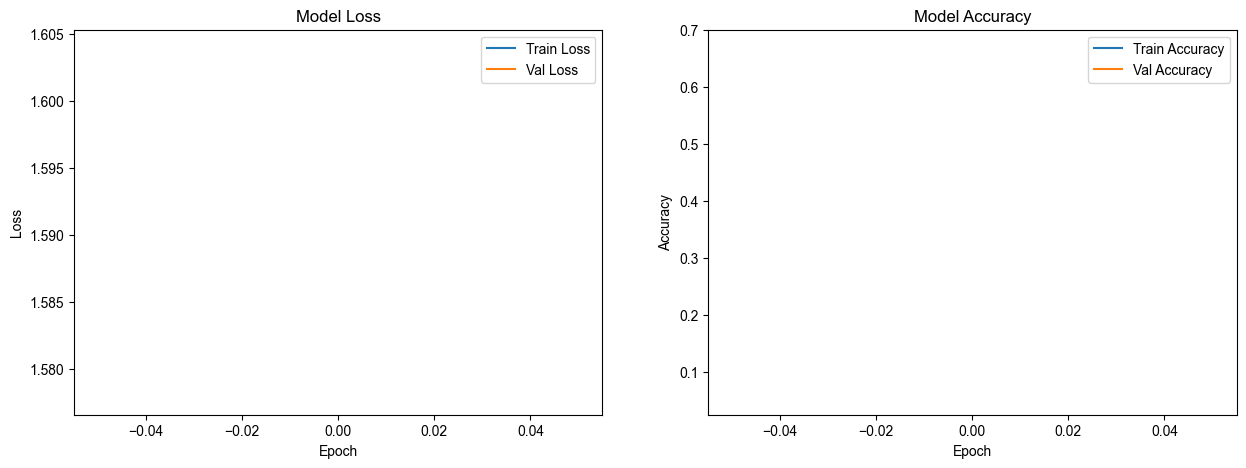

In [13]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['val_losses'], label='Val Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracies
    ax2.plot(history['train_accuracies'], label='Train Accuracy')
    ax2.plot(history['val_accuracies'], label='Val Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.show()

plot_training_history(history)